## Классификация постов
Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


tf-nightly нужен, т.к. f.keras.metrics.F1Score работает только для tf-nightly. См. https://www.tensorflow.org/api_docs/python/tf/keras/metrics/F1Score

In [2]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [167]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина поста
max_len = 11
# Количество классов
nb_classes = 15

## Загрузка набора данных

In [168]:
df_em_1_token_10 = pd.read_csv('df_em_1_token_10.csv', sep=";")

In [169]:
df_em_1_token_10

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
0,😂,5,1,smile,positive/negative,0,почему бы и нет 😂
1,😁,5,1,smile,positive/negative,0,как сесть на диету 😁
2,😁,6,1,smile,positive/negative,0,когда в душе ещё щенок 😁
3,😻,6,1,joy,positive,2,новые фотографии нюши просто огненные😻
4,😍,7,1,joy,positive,2,безумно красивая актриса - алина ланина 😍
...,...,...,...,...,...,...,...
9215,😄,5,1,smile,positive/negative,0,ряды эскортниц скоро пополнится 😄
9216,😂,7,1,smile,positive/negative,0,так он прав ты реально даун 😂
9217,🤔,7,1,no_emotion,neutral/skeptical,1,вы же не про меня?🤔
9218,🤔,9,1,no_emotion,neutral/skeptical,1,про кого пошутил то это не до комик🤔


In [170]:
train, test = train_test_split(df_em_1_token_10, test_size=0.2)

In [171]:
train

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
6798,😂,7,1,smile,positive/negative,0,лиш бы не либерал-демократ!)😂
8612,😌,8,1,joy,positive,2,ох как много вам предстоит ещё узнать 😌
8524,😢,5,1,sadness,negative,4,вот бы мне так 😢
343,😍,10,1,joy,positive,2,kpaсoтка кэти пeрpи и eё любoвь к кopoтким юбo...
2292,🤣,8,1,smile,positive/negative,0,а что вам мешает???🤣
...,...,...,...,...,...,...,...
8600,😂,6,1,smile,positive/negative,0,каждый останется при своем мнении 😂
4205,😅,4,1,smile,positive/negative,0,это которое? 😅
2281,😁,4,1,smile,positive/negative,0,светлая - кокошка 😁
7761,😏,4,1,no_emotion,neutral/skeptical,1,п@здят поверьте😏


In [172]:
test

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
6561,😄,3,1,smile,positive/negative,0,компостер называется😄
6203,🤣,5,1,smile,positive/negative,0,"пипец,особенно лягушонок! 🤣"
1661,😃,9,1,smile,positive/negative,0,очень круто! умеют же джигиты классно танцевать 😃
5596,😁,7,1,smile,positive/negative,0,на отработке потом обратно в машину 😁
7677,🤣,10,1,smile,positive/negative,0,да это продавец нарывается.я просто бы помог🤣
...,...,...,...,...,...,...,...
5261,😂,4,1,smile,positive/negative,0,он самый... 😂
1813,😅,10,1,smile,positive/negative,0,как же оле бузовой и рудковской подходят эти н...
6740,😊,6,1,smile,positive/negative,0,куда тебе вискас отправить? 😊
3127,😹,3,1,smile,positive/negative,0,хахахах урыл😹


Выделяем данные для обучения

In [173]:
posts_train = train['clean_text']
posts_test = test['clean_text']

In [174]:
posts_train[:5]

6798                        лиш бы не либерал-демократ!)😂
8612              ох как много вам предстоит ещё узнать 😌
8524                                     вот бы мне так 😢
343     kpaсoтка кэти пeрpи и eё любoвь к кopoтким юбo...
2292                                 а что вам мешает???🤣
Name: clean_text, dtype: object

In [175]:
posts_test[:5]

6561                                компостер называется😄
6203                          пипец,особенно лягушонок! 🤣
1661    очень круто! умеют же джигиты классно танцевать 😃
5596                на отработке потом обратно в машину 😁
7677        да это продавец нарывается.я просто бы помог🤣
Name: clean_text, dtype: object

Выделяем правильные ответы

In [176]:
y_train = utils.to_categorical(train['class'], nb_classes)

In [177]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [178]:
y_test = utils.to_categorical(test['class'], nb_classes)

In [179]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

## Токенизация текста

Создаем токенизатор Keras

In [180]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на постах

In [181]:
tokenizer.fit_on_texts(posts_train)

Просматриваем словарь токенизатора

In [182]:
tokenizer.word_index

{'не': 1,
 'и': 2,
 'в': 3,
 '🤣': 4,
 'а': 5,
 'это': 6,
 'я': 7,
 '😂': 8,
 'что': 9,
 'на': 10,
 '😁': 11,
 'у': 12,
 'так': 13,
 'как': 14,
 'с': 15,
 '😅': 16,
 'то': 17,
 'ты': 18,
 'ну': 19,
 '😄': 20,
 'да': 21,
 'же': 22,
 '🤔': 23,
 'вот': 24,
 'все': 25,
 'за': 26,
 'по': 27,
 'тоже': 28,
 'вы': 29,
 '😉': 30,
 '😊': 31,
 'он': 32,
 'уже': 33,
 '😆': 34,
 '😏': 35,
 'мне': 36,
 'когда': 37,
 'бы': 38,
 'меня': 39,
 'просто': 40,
 'только': 41,
 'из': 42,
 'ещё': 43,
 'она': 44,
 '😍': 45,
 'для': 46,
 'есть': 47,
 'если': 48,
 'они': 49,
 'там': 50,
 'спасибо': 51,
 'от': 52,
 'но': 53,
 'нет': 54,
 'кто': 55,
 '😎': 56,
 'очень': 57,
 '😃': 58,
 'к': 59,
 'всё': 60,
 'его': 61,
 'тебя': 62,
 'может': 63,
 'было': 64,
 'будет': 65,
 'надо': 66,
 'даже': 67,
 'без': 68,
 '❤': 69,
 'лучше': 70,
 '😳': 71,
 'или': 72,
 'вам': 73,
 'можно': 74,
 'вас': 75,
 'какой': 76,
 'где': 77,
 'до': 78,
 'тебе': 79,
 'этот': 80,
 'тут': 81,
 'тогда': 82,
 'вообще': 83,
 'точно': 84,
 'чем': 85,
 'о': 86

Преобразуем посты в числовое представление

In [183]:
sequences_train = tokenizer.texts_to_sequences(posts_train)

In [184]:
index = 0
print(posts_train[index])
print(sequences_train[index])

почему бы и нет 😂
[3034, 38, 1, 3035, 3036, 8]


In [185]:
tokenizer.word_index['нет']

54

In [186]:
sequences_test = tokenizer.texts_to_sequences(posts_test)

Ограничиваем длину постов

In [187]:
x_train = pad_sequences(sequences_train, maxlen=max_len)

In [188]:
x_test = pad_sequences(sequences_test, maxlen=max_len)

In [189]:
x_train[:5]

array([[   0,    0,    0,    0,    0, 3034,   38,    1, 3035, 3036,    8],
       [   0,    0,    0,  490,   14,  374,   73, 3037,   43,  533,  111],
       [   0,    0,    0,    0,    0,    0,   24,   38,   36,   13,  120],
       [   0, 3038, 3039, 3040,    2, 3041, 3042,   59, 3043, 3044,   45],
       [   0,    0,    0,    0,    0,    0,    5,    9,   73, 1676,    4]],
      dtype=int32)

In [190]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 4719,  306,    4],
       [   0,    0,    0,    0,    0,   57, 1019, 1040,   22,  980,   58],
       [   0,    0,    0,    0,    0,   10,  180, 1074,    3, 4317,   11],
       [   0,    0,    0,    0,    0,    0,   21,    6,    7,   40,   38]],
      dtype=int32)

In [102]:
#def recall_m(y_true, y_pred):
 #   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
   # recall = true_positives / (possible_positives + K.epsilon())
   # return recall

In [103]:
#def precision_m(y_true, y_pred):
 #   true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
   # precision = true_positives / (predicted_positives + K.epsilon())
    #return precision

In [104]:
#def f1_m(y_true, y_pred):
 #   precision = precision_m(y_true, y_pred)
  #  recall = recall_m(y_true, y_pred)
   # return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Сверточная нейронная сеть

In [191]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(15, activation='softmax'))

In [192]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [193]:
model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 11, 32)            320000    
                                                                 
 conv1d_6 (Conv1D)           (None, 7, 250)            40250     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 250)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 128)               32128     
                                                                 
 dense_15 (Dense)            (None, 15)                1935      
                                                                 
Total params: 394313 (1.50 MB)
Trainable params: 394313 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [194]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      #monitor='val_f1_score_weighted',
                                      save_best_only=True,
                                      verbose=1)

In [195]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/5
52/52 [==============================] - ETA: 0s - loss: 1.7314 - accuracy: 0.6314 - precision_9: 0.6397 - recall_9: 0.3747 - f1_score_macro: 0.0529 - f1_score_micro: 0.6314 - f1_score_weighted: 0.5047
Epoch 1: val_loss improved from inf to 1.42741, saving model to best_model_cnn.h5
52/52 [==============================] - 8s 128ms/step - loss: 1.7314 - accuracy: 0.6314 - precision_9: 0.6397 - recall_9: 0.3747 - f1_score_macro: 0.0529 - f1_score_micro: 0.6314 - f1_score_weighted: 0.5047 - val_loss: 1.4274 - val_accuracy: 0.6192 - val_precision_9: 0.6211 - val_recall_9: 0.6152 - val_f1_score_macro: 0.0510 - val_f1_score_micro: 0.6192 - val_f1_score_weighted: 0.4736
Epoch 2/5
 1/52 [..............................] - ETA: 5s - loss: 1.3880 - accuracy: 0.6328 - precision_9: 0.6452 - recall_9: 0.6250 - f1_score_macro: 0.0517 - f1_score_micro: 0.6328 - f1_score_weighted: 0.4905

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/52 [============================>.] - ETA: 0s - loss: 1.1884 - accuracy: 0.6478 - precision_9: 0.7166 - recall_9: 0.5938 - f1_score_macro: 0.0524 - f1_score_micro: 0.6478 - f1_score_weighted: 0.5094
Epoch 2: val_loss improved from 1.42741 to 1.18413, saving model to best_model_cnn.h5
52/52 [==============================] - 3s 50ms/step - loss: 1.1887 - accuracy: 0.6470 - precision_9: 0.7176 - recall_9: 0.5917 - f1_score_macro: 0.0524 - f1_score_micro: 0.6470 - f1_score_weighted: 0.5084 - val_loss: 1.1841 - val_accuracy: 0.6192 - val_precision_9: 0.8342 - val_recall_9: 0.4363 - val_f1_score_macro: 0.0510 - val_f1_score_micro: 0.6192 - val_f1_score_weighted: 0.4736
Epoch 3/5
52/52 [==============================] - ETA: 0s - loss: 0.8575 - accuracy: 0.7314 - precision_9: 0.9611 - recall_9: 0.6357 - f1_score_macro: 0.1258 - f1_score_micro: 0.7314 - f1_score_weighted: 0.6552
Epoch 3: val_loss improved from 1.18413 to 1.02235, saving model to best_model_cnn.h5
52/52 [===================

смотрим на f1_weighted, т.к. датасет несбалансирован

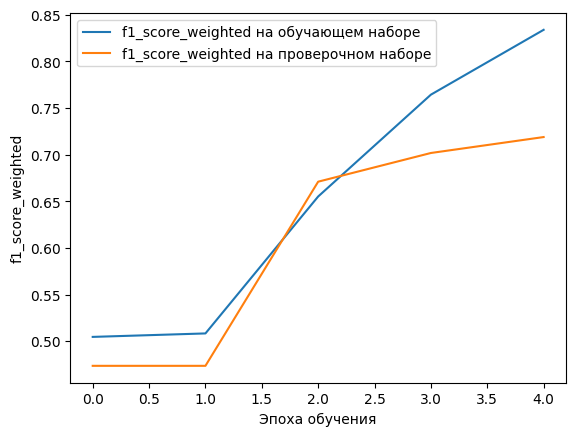

In [196]:
plt.plot(history_cnn.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_cnn.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

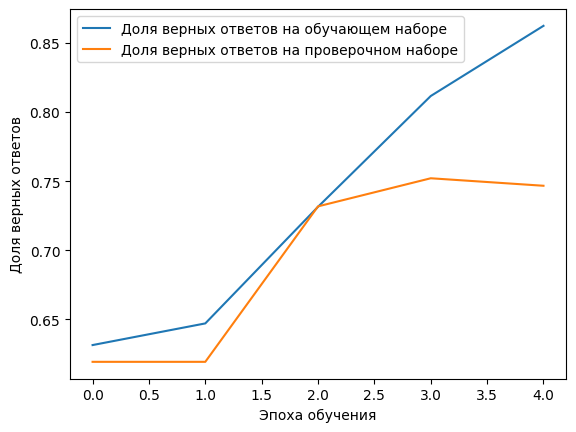

In [197]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [198]:
cnn_loaded = load_model("best_model_cnn.h5")

In [199]:
cnn_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 6ms/step - loss: 0.9190 - accuracy: 0.7652 - precision_9: 0.9012 - recall_9: 0.6133 - f1_score_macro: 0.1742 - f1_score_micro: 0.7652 - f1_score_weighted: 0.7154


[0.9190302491188049,
 0.7651844024658203,
 0.901195228099823,
 0.6133405566215515,
 0.17415374517440796,
 0.7651844024658203,
 0.7154281139373779]

In [255]:
predicted_cnn = cnn_loaded.predict(x_test)

58/58 [==============================] - 0s 2ms/step


In [259]:
import sklearn.metrics as sklearn_metrics
import numpy as np

In [260]:
np.argmax(predicted_cnn, axis=1) 

array([0, 0, 0, ..., 0, 0, 2])

In [263]:
#print(sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_cnn, axis=1)))

In [262]:
clf_name = predicted_cnn.__class__.__name__
clf_name

'ndarray'

In [274]:
report_cnn = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_cnn, axis=1))
print(report_cnn)

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1202
           1       0.82      0.76      0.79       188
           2       0.79      0.61      0.69       140
           3       0.23      0.31      0.26        91
           4       0.00      0.00      0.00        84
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        29
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3

    accuracy                           0.77      1844
   macro avg       0.18      0.18      0.17      1844
weighted avg       0.68   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [275]:
with open("CNN_5.txt", 'w') as w_file:
  w_file.write(report_cnn)

## Cеть LSTM

In [200]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(15, activation='softmax'))

In [201]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [202]:
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 11, 32)            320000    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_16 (Dense)            (None, 15)                255       
                                                                 
Total params: 323391 (1.23 MB)
Trainable params: 323391 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [203]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      #monitor='val_f1_score_weighted',
                                      save_best_only=True,
                                      verbose=1)

In [204]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
52/52 [==============================] - ETA: 0s - loss: 2.3341 - accuracy: 0.6124 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - f1_score_macro: 0.0591 - f1_score_micro: 0.6124 - f1_score_weighted: 0.5057
Epoch 1: val_loss improved from inf to 1.56508, saving model to best_model_lstm.h5
52/52 [==============================] - 7s 93ms/step - loss: 2.3341 - accuracy: 0.6124 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - f1_score_macro: 0.0591 - f1_score_micro: 0.6124 - f1_score_weighted: 0.5057 - val_loss: 1.5651 - val_accuracy: 0.6192 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score_macro: 0.0510 - val_f1_score_micro: 0.6192 - val_f1_score_weighted: 0.4736
Epoch 2/5
52/52 [==============================] - ETA: 0s - loss: 1.3771 - accuracy: 0.6470 - precision_10: 0.6500 - recall_10: 0.6109 - f1_score_macro: 0.0524 - f1_score_micro: 0.6470 - f1_score_weighted: 0.5084
Epoch 2: val_loss improved from 1.56508 to 1.39627, saving model to best_

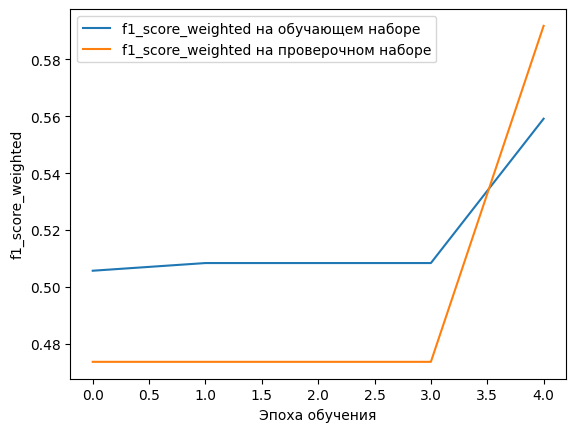

In [205]:
plt.plot(history_lstm.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_lstm.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

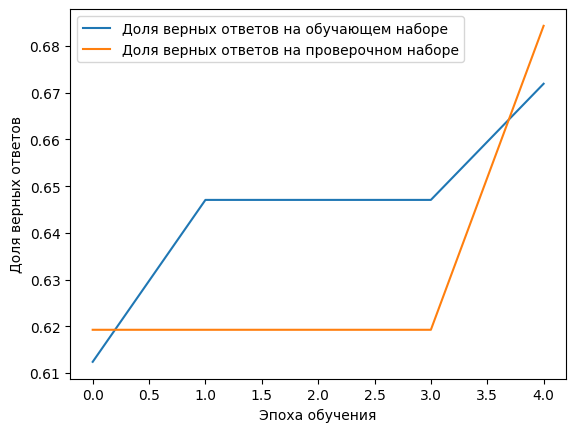

In [206]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [207]:
lstm_loaded = load_model("best_model_lstm.h5")

In [208]:
lstm_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 4ms/step - loss: 1.0204 - accuracy: 0.7148 - precision_10: 0.8407 - recall_10: 0.6497 - f1_score_macro: 0.1185 - f1_score_micro: 0.7148 - f1_score_weighted: 0.6266


[1.0204014778137207,
 0.7147505283355713,
 0.8407017588615417,
 0.6496745944023132,
 0.11853731423616409,
 0.7147505283355713,
 0.6266276836395264]

In [266]:
predicted_lstm = lstm_loaded.predict(x_test)

58/58 [==============================] - 1s 2ms/step


In [267]:
report_lstm = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_lstm, axis=1))
print(report_lstm)

              precision    recall  f1-score   support

           0       0.70      1.00      0.83      1202
           1       0.99      0.45      0.62       188
           2       0.64      0.23      0.34       140
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        84
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        29
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3

    accuracy                           0.71      1844
   macro avg       0.16      0.11      0.12      1844
weighted avg       0.61   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [270]:
with open("LSTM_5.txt", 'w') as w_file:
  w_file.write(report_lstm)

## Cеть GRU

In [215]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_len))
model_gru.add(GRU(16))
model_gru.add(Dense(15, activation='softmax'))

In [216]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
               metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.F1Score(average='macro', name='f1_score_macro'), metrics.F1Score(average='micro', name='f1_score_micro'), metrics.F1Score(average='weighted', name='f1_score_weighted')]
              )

In [217]:
model_gru.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 11, 32)            320000    
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dense_18 (Dense)            (None, 15)                255       
                                                                 
Total params: 322655 (1.23 MB)
Trainable params: 322655 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model_gru.h5

In [218]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      #monitor='val_f1_score_weighted',
                                      save_best_only=True,
                                      verbose=1)

In [219]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
52/52 [==============================] - ETA: 0s - loss: 2.4712 - accuracy: 0.5899 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - f1_score_macro: 0.0628 - f1_score_micro: 0.5899 - f1_score_weighted: 0.5006
Epoch 1: val_loss improved from inf to 1.94041, saving model to best_model_gru.h5
52/52 [==============================] - 7s 93ms/step - loss: 2.4712 - accuracy: 0.5899 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - f1_score_macro: 0.0628 - f1_score_micro: 0.5899 - f1_score_weighted: 0.5006 - val_loss: 1.9404 - val_accuracy: 0.6192 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - val_f1_score_macro: 0.0510 - val_f1_score_micro: 0.6192 - val_f1_score_weighted: 0.4736
Epoch 2/5
52/52 [==============================] - ETA: 0s - loss: 1.4040 - accuracy: 0.6470 - precision_12: 0.6843 - recall_12: 0.4604 - f1_score_macro: 0.0524 - f1_score_micro: 0.6470 - f1_score_weighted: 0.5084
Epoch 2: val_loss improved from 1.94041 to 1.27621, saving model to best_m

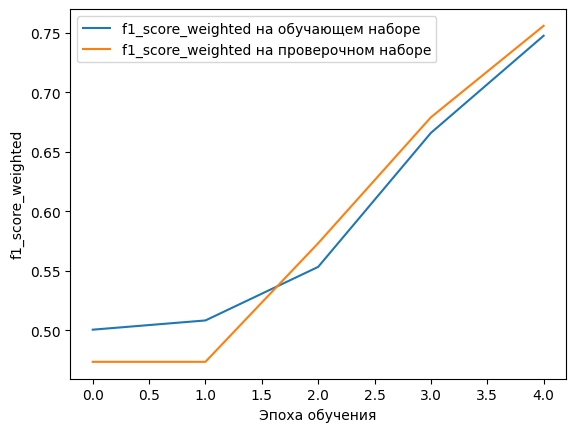

In [220]:
plt.plot(history_gru.history['f1_score_weighted'], 
         label='f1_score_weighted на обучающем наборе')
plt.plot(history_gru.history['val_f1_score_weighted'], 
         label='f1_score_weighted на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('f1_score_weighted')
plt.legend()
plt.show()

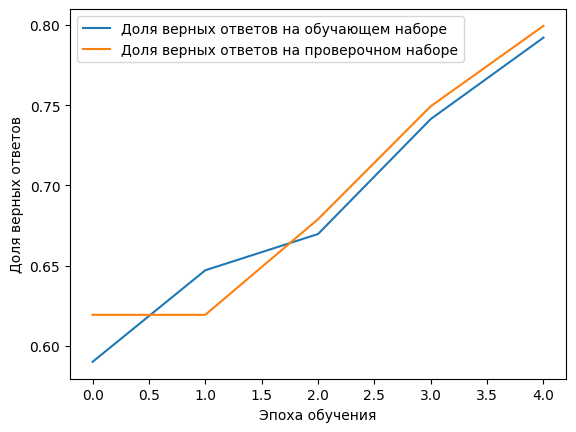

In [221]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [225]:
gru_loaded = load_model("best_model_gru.h5")

In [226]:
gru_loaded.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 1s 4ms/step - loss: 0.7975 - accuracy: 0.8221 - precision_12: 0.8697 - recall_12: 0.7457 - f1_score_macro: 0.2829 - f1_score_micro: 0.8221 - f1_score_weighted: 0.7842


[0.7975316643714905,
 0.8221257925033569,
 0.8697026968002319,
 0.7456616163253784,
 0.282873272895813,
 0.8221257925033569,
 0.7841952443122864]

In [271]:
predicted_gru = gru_loaded.predict(x_test)

58/58 [==============================] - 1s 3ms/step


In [272]:
report_gru = sklearn_metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predicted_gru, axis=1))
print(report_gru)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1202
           1       0.82      0.72      0.77       188
           2       0.72      0.56      0.63       140
           3       1.00      0.40      0.57        91
           4       0.82      0.48      0.60        84
           5       0.00      0.00      0.00        18
           6       0.74      0.79      0.77        29
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        11
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3

    accuracy                           0.82      1844
   macro avg       0.33      0.26      0.28      1844
weighted avg       0.78   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [273]:
with open("GRU_5.txt", 'w') as w_file:
  w_file.write(report_gru)

## Загружаем набор данных для тестирования


In [228]:
test

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
6561,😄,3,1,smile,positive/negative,0,компостер называется😄
6203,🤣,5,1,smile,positive/negative,0,"пипец,особенно лягушонок! 🤣"
1661,😃,9,1,smile,positive/negative,0,очень круто! умеют же джигиты классно танцевать 😃
5596,😁,7,1,smile,positive/negative,0,на отработке потом обратно в машину 😁
7677,🤣,10,1,smile,positive/negative,0,да это продавец нарывается.я просто бы помог🤣
...,...,...,...,...,...,...,...
5261,😂,4,1,smile,positive/negative,0,он самый... 😂
1813,😅,10,1,smile,positive/negative,0,как же оле бузовой и рудковской подходят эти н...
6740,😊,6,1,smile,positive/negative,0,куда тебе вискас отправить? 😊
3127,😹,3,1,smile,positive/negative,0,хахахах урыл😹


Преобразуем посты в числовое представление

Нужно использовать токенизатор, обученный на наборе данных train.

In [229]:
test_sequences = tokenizer.texts_to_sequences(test['clean_text'])

In [230]:
x_test = pad_sequences(test_sequences, maxlen=max_len)

In [231]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 4719,  306,    4],
       [   0,    0,    0,    0,    0,   57, 1019, 1040,   22,  980,   58],
       [   0,    0,    0,    0,    0,   10,  180, 1074,    3, 4317,   11],
       [   0,    0,    0,    0,    0,    0,   21,    6,    7,   40,   38]],
      dtype=int32)

Правильные ответы

In [232]:
y_test = utils.to_categorical(test['class'], nb_classes)

In [233]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

## Оцениваем качество работы сети на тестовом наборе данных


### Одномерная сверточная сеть

In [234]:
model_cnn.load_weights(model_cnn_save_path)

In [235]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_cnn.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 6ms/step - loss: 0.9190 - accuracy: 0.7652 - precision_9: 0.9012 - recall_9: 0.6133 - f1_score_macro: 0.1742 - f1_score_micro: 0.7652 - f1_score_weighted: 0.7154


### Сеть LSTM

In [236]:
model_lstm.load_weights(model_lstm_save_path)

In [237]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_lstm.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 5ms/step - loss: 1.0204 - accuracy: 0.7148 - precision_10: 0.8407 - recall_10: 0.6497 - f1_score_macro: 0.1185 - f1_score_micro: 0.7148 - f1_score_weighted: 0.6266


### Сеть GRU

In [238]:
model_gru.load_weights(model_gru_save_path)

In [239]:
loss, accuracy, precision, recall, f1_score_macro, f1_score_micro, f1_score_weighted = model_gru.evaluate(x_test, y_test, verbose=1)

58/58 [==============================] - 0s 5ms/step - loss: 0.7975 - accuracy: 0.8221 - precision_12: 0.8697 - recall_12: 0.7457 - f1_score_macro: 0.2829 - f1_score_micro: 0.8221 - f1_score_weighted: 0.7842


In [241]:
test['clean_text'][1246]
#test['clean_text'][2384]

'махнем со мной на небо ❤'

In [242]:
#test['class'][2384], test['emotion'][2384], test['tonality'][2384]
test['class'][1246], test['emotion'][1246], test['tonality'][1246]

(2, 'joy', 'positive')

In [243]:
#text = test['clean_text'][2384]
text = test['clean_text'][1246]

In [244]:
sequence = tokenizer.texts_to_sequences([text])

In [245]:
sequence

[[153, 2057, 10, 69]]

In [246]:
data = pad_sequences(sequence, maxlen=max_len)

In [247]:
data

array([[   0,    0,    0,    0,    0,    0,    0,  153, 2057,   10,   69]],
      dtype=int32)

In [248]:
emoji_dict = {"0":"smile positive/negative", "1":"no_emotion neutral/skeptical", "2":"joy positive",
              "3":"no_emotion positive/negative", "4":"sadness negative", "5":"fear negative",
              "6":"shame negative","7":"anger negative", "8":"disgust negative",
              "9":"surprise positive/negative","10":"disgust neutral/skeptical", "11":"surprise negative",
              "12":"no_emotion negative","13":"sadness positive/negative", "14":"fear positive/negative"}

### Одномерная сверточная сеть

In [249]:
result_cnn = model_cnn.predict(data)

1/1 [==============================] - 0s 101ms/step


In [250]:
result_cnn

array([[2.7884901e-04, 4.3033587e-04, 8.0698723e-01, 1.8214412e-01,
        9.5010828e-03, 2.7501074e-04, 4.8169441e-05, 7.3370160e-05,
        7.2142895e-05, 8.3471372e-05, 1.4429457e-05, 3.6681704e-05,
        3.8985258e-05, 1.5640549e-05, 4.0026055e-07]], dtype=float32)

### Сеть LSTM

In [251]:
result_lstm = model_lstm.predict(data)

1/1 [==============================] - 0s 355ms/step


In [252]:
result_lstm

array([[0.24158093, 0.15515046, 0.19687346, 0.09729096, 0.07952406,
        0.05209929, 0.02319434, 0.0234726 , 0.03399733, 0.02680601,
        0.01391194, 0.01130754, 0.02026326, 0.01501474, 0.00951311]],
      dtype=float32)

### Сеть GRU

In [253]:
result_gru = model_gru.predict(data)

1/1 [==============================] - 0s 325ms/step


In [254]:
result_gru

array([[0.15749276, 0.01091314, 0.6121168 , 0.02702023, 0.03465582,
        0.00894367, 0.02884191, 0.02604786, 0.01213347, 0.01380449,
        0.02096184, 0.01841285, 0.0033628 , 0.01180408, 0.01348835]],
      dtype=float32)